In [2]:
%matplotlib inline
from pycocotools.coco import COCO

import pandas as pd

# 단어사전 생성
from collections import Counter
import string
import re
import nltk
nltk.download('punkt')
import pickle

# torch
import torchvision
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
import torch.optim as optim
import torch.utils.data as data

# 시각화
import seaborn as sns

import numpy as np
import random
import skimage.io as io

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

[nltk_data] Downloading package punkt to /Users/shin-
[nltk_data]     ahreum/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## coco API 초기화

In [4]:
#data_dir='/Users/shin-ahreum/Documents/graduation_project/code/Mirror-DL/rawdataset/coco'
data_dir='../../rawdataset/coco'
data_type='val2017'

# annotation 파일 위치
ann_file='{}/annotations/instances_{}.json'.format(data_dir, data_type)
coco = COCO(ann_file)           # pycocotools의 coco api 사용하여 annotation 가져오기

# caption 파일 위치
cap_file='{}/annotations/captions_{}.json'.format(data_dir, data_type)
coco_caps = COCO(cap_file)      # pycocotools의 coco api 사용하여 caption 가져오기

# 로컬 이미지 저장 경로
img_folder='{}/{}'.format(data_dir, data_type)

loading annotations into memory...
Done (t=0.28s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


## 사용 가능 데이터 분리

사용 가능한 이미지 분리해서 필요한 캡션id, 이미지id, 이미지 이름, 캡션 데이터 가져오기

In [5]:
all_image_ids = coco.getImgIds()
img_ids = [] # 사용할 데이터들 id
no_anno_ids = [] # 사용하지 않을 데이터들 id

for idx in all_image_ids:
    annotations_ids = coco.getAnnIds(imgIds=idx, iscrowd=False)
    if len(annotations_ids) == 0 :
        no_anno_ids.append(idx)
    else :
        img_ids.append(idx)
        
print('전체 이미지 개수 : {}'.format(len(all_image_ids)))
print('사용가능 이미지 개수 : {}'.format(len(img_ids)))
print('사용불가 이미지 개수 : {}'.format(len(no_anno_ids)))

전체 이미지 개수 : 5000
사용가능 이미지 개수 : 4952
사용불가 이미지 개수 : 48


In [6]:
image_ids = []
file_names = []
ids = []
captions = []

for i in range(len(img_ids)) :
    ann_ids = coco_caps.getAnnIds(imgIds = img_ids[i])
    anns = coco_caps.loadAnns(ann_ids)
    
    file_name = coco.loadImgs(img_ids[i])[0]['file_name']
    
    for j in range(len(anns)) :
        image_ids.append(anns[j]['image_id'])
        file_names.append(file_name)
        ids.append(anns[j]['id'])
        captions.append(anns[j]['caption'])

In [7]:
df = pd.DataFrame({'ann_id':ids, 'image_id':image_ids, 'file_name':file_names, 'caption':captions},
    columns = ['ann_id','image_id','file_name','caption'])
df

,ann_id,image_id,file_name,caption
0,370509,397133,000000397133.jpg,A man is in a kitchen making pizzas.
1,370584,397133,000000397133.jpg,Man in apron standing on front of oven with pa...
2,372252,397133,000000397133.jpg,A baker is working in the kitchen rolling dough.
3,372765,397133,000000397133.jpg,A person standing by a stove in a kitchen.
4,375891,397133,000000397133.jpg,A table with pies being made and a person stan...
...,...,...,...,...
24769,505078,15335,000000015335.jpg,A group of people sitting at a table with food.
24770,505954,15335,000000015335.jpg,"A man, woman, and boy are sitting at a table."
24771,505978,15335,000000015335.jpg,"A man, woman and child eating together at a re..."
24772,507940,15335,000000015335.jpg,A boy sitting between a man and a woman.


In [8]:
def unique(l):
    if len(l)==len(set(l)):
        print("The List is Unique!")
        return True
    else:
        print("The List is Not Unique!")
        return False

unique(ids)

The List is Unique!


True

## 단어 임베딩 및 사전 구축

### 캡션 문장 소문자화 및 특수문자 제거

In [9]:
regex = re.compile('[%s]' % re.escape(string.punctuation))

def clean_text(text):
    text = str(text).strip()
    text = text.lower()
    return regex.sub("", text)

df['caption'] = df['caption'].apply(clean_text)
df['length'] = df['caption'].apply(lambda row: len(row.strip().split()))

In [10]:
df.head()

,ann_id,image_id,file_name,caption,length
0,370509,397133,000000397133.jpg,a man is in a kitchen making pizzas,8
1,370584,397133,000000397133.jpg,man in apron standing on front of oven with pa...,12
2,372252,397133,000000397133.jpg,a baker is working in the kitchen rolling dough,9
3,372765,397133,000000397133.jpg,a person standing by a stove in a kitchen,9
4,375891,397133,000000397133.jpg,a table with pies being made and a person stan...,21


In [11]:
csv_filename = 'pro_cap_{}.csv'.format(data_type)
df.to_csv(csv_filename, index=False)

/var/folders/2t/y5m4cyqs2rl6j_09s0v3tmdh0000gn/T/ipykernel_7364/2336548994.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.displot(data=df, x='length', palette='mako', kind='kde', fill=True, aspect=4)


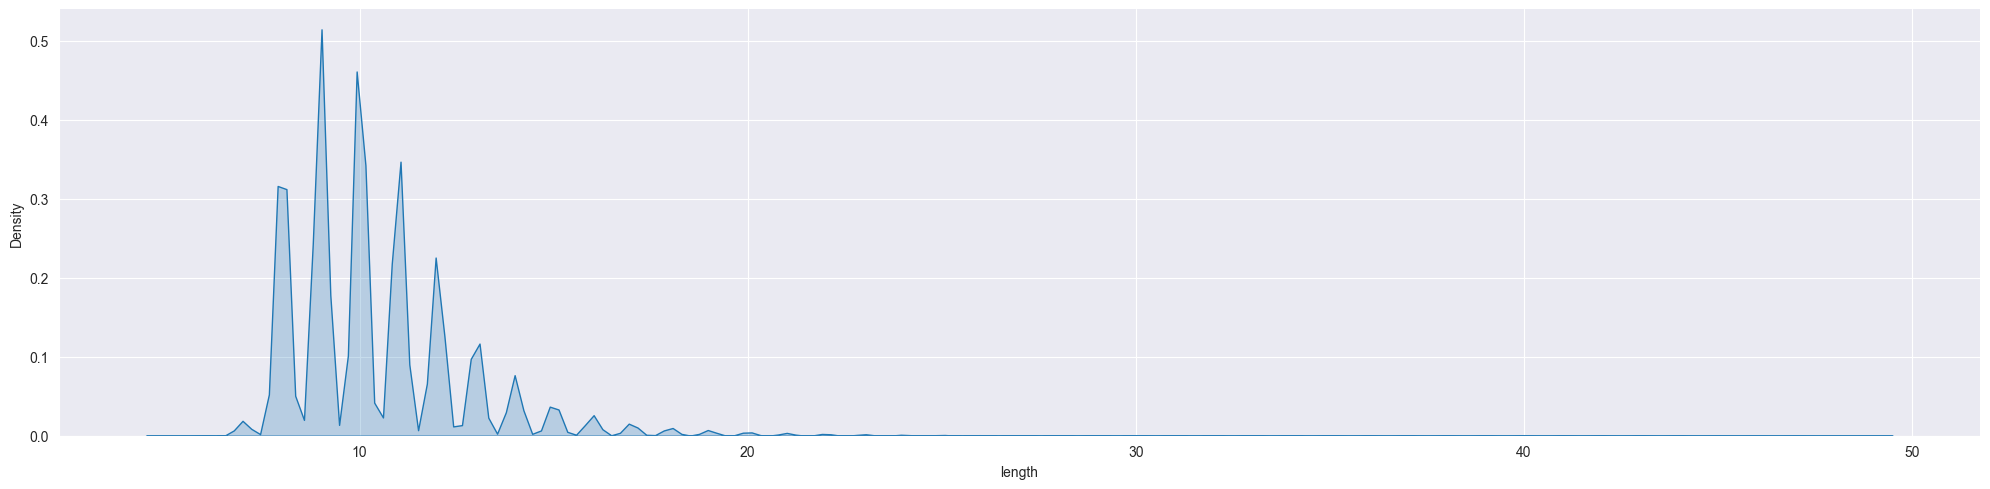

In [10]:
# 단어 개수의 분포 파악
sns.displot(data=df, x='length', palette='mako', kind='kde', fill=True, aspect=4)

In [11]:
# 각 단어의 빈도수 파악
captions = df['caption'].tolist()

word_freq = {}

for comment in captions:
    comment = comment.strip()
    for word in comment.split():
        if word not in word_freq:
            word_freq[word] = 0
        word_freq[word] += 1

dict(sorted(word_freq.items(), key=lambda item: item[1], reverse = True)[:10])

{'a': 971343,
 'on': 214017,
 'of': 201915,
 'the': 195875,
 'in': 182790,
 'with': 153478,
 'and': 139608,
 'is': 97452,
 'man': 73013,
 'to': 67397}

### caption으로 단어 사전 만들기 (단순)

In [12]:
captions[:5]

['a man with a red helmet on a small moped on a dirt road',
 'man riding a motor bike on a dirt road on the countryside',
 'a man riding on the back of a motorcycle',
 'a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloudwreathed mountains',
 'a man in a red shirt and a red hat is on a motorcycle on a hill side']

In [13]:
class Vocabulary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
    
    # word랑 
    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1
        
    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]
    
    def __len__(self):
        return len(self.word2idx)

In [14]:
vocab_path = './train_captions_vocab.pkl'
vocab = Vocabulary()            # 나오는 단어들을 저장
counter = Counter()             # caption들에 나오는 단어 리스트를 구성하고, 해당 단어가 몇번 나오는지 counter에 저장.
word_threshold = 3              # 단어가 4번 이상 나오면 vocab에 저장할 예정


vocab.add_word('<pad>')         # 문장의 길이를 맞춰주기 위한 토큰(모든 시퀀스를 특정 길이로 맞추기 위해 나머지 부분을 패딩 토큰으로 채움.)
vocab.add_word('<start>')       # 문장의 시작
vocab.add_word('<end>')         # 문장의 끝
vocab.add_word('<unk>')         # 모델이 학습 중에 처음 보는 단어를 나타내는 토큰


for i in range(len(captions)):
    caption = captions[i]
    
    tokens = nltk.tokenize.word_tokenize(caption)
    counter.update(tokens)
    
words = [word for word, cnt in counter.items() if cnt >= word_threshold]

for word in words:
    vocab.add_word(word)

with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)

In [11]:
len(vocab.word2idx)

13186

In [16]:
vocab.word2idx

{'<pad>': 0,
 '<start>': 1,
 '<end>': 2,
 '<unk>': 3,
 'a': 4,
 'man': 5,
 'with': 6,
 'red': 7,
 'helmet': 8,
 'on': 9,
 'small': 10,
 'moped': 11,
 'dirt': 12,
 'road': 13,
 'riding': 14,
 'motor': 15,
 'bike': 16,
 'the': 17,
 'countryside': 18,
 'back': 19,
 'of': 20,
 'motorcycle': 21,
 'path': 22,
 'young': 23,
 'person': 24,
 'rests': 25,
 'to': 26,
 'foreground': 27,
 'verdant': 28,
 'area': 29,
 'bridge': 30,
 'and': 31,
 'background': 32,
 'mountains': 33,
 'in': 34,
 'shirt': 35,
 'hat': 36,
 'is': 37,
 'hill': 38,
 'side': 39,
 'woman': 40,
 'wearing': 41,
 'net': 42,
 'her': 43,
 'head': 44,
 'cutting': 45,
 'cake': 46,
 'large': 47,
 'white': 48,
 'sheet': 49,
 'hair': 50,
 'there': 51,
 'that': 52,
 'marking': 53,
 'chefs': 54,
 'knife': 55,
 'child': 56,
 'holding': 57,
 'flowered': 58,
 'umbrella': 59,
 'petting': 60,
 'yak': 61,
 'an': 62,
 'next': 63,
 'herd': 64,
 'cattle': 65,
 'boy': 66,
 'barefoot': 67,
 'touching': 68,
 'horn': 69,
 'cow': 70,
 'who': 71,
 'whil

### bert imbedding vocab 구성